In [1]:
import jax
import jax.scipy.stats as jst
from jax.random import PRNGKey, normal, split
import matplotlib.pyplot as plt
import numpy as np
from blackjax.diagnostics import effective_sample_size

from kernels import kernel_factory
from utils import *
from integrators import *
from functools import partial

# root_seed=12338
root_seed=123875938 # alrighty
key = PRNGKey(root_seed)

2023-03-25 18:30:48.999703: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-25 18:30:49.192058: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-25 18:30:49.193568: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-25 18:30:50.711667: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-25 18:30:50.711713: W external/org

In [2]:
dim = 2
mu = np.zeros(dim)
# cov = jnp.array([[2.0, 0.4],[0.3,.5]])
diag = np.linspace(1/dim,1,dim) # stds
cov = np.diag(diag**2) # std is the square root of the eigenvalues of cov
# cov = np.diag(np.ones(2))
gaussian = lambda x: jst.multivariate_normal.pdf(x, mu, cov)
U = lambda x: -jst.multivariate_normal.logpdf(x, mu, cov)

num_samples=100000
q_init = normal(key, (dim, ))
init_step_size=.5
keys = split(key, num=num_samples)

init_state, hmc_kernel = kernel_factory("hmc", q_init, init_step_size, U, explicit_leapfrog)
carry, samples = jax.lax.scan(hmc_kernel, init_state, keys)

In [3]:
p_init = jnp.array([-1.0, 1.0])
n = 100

def fun(state, sth):
    q,p = explicit_leapfrog(*state, step_size=.1, num_steps=1, M=1.0, dUdq=jax.grad(U))
    return (q,-p), state[0]
_, trajectory = jax.lax.scan(fun, (q_init, p_init), jnp.arange(n))

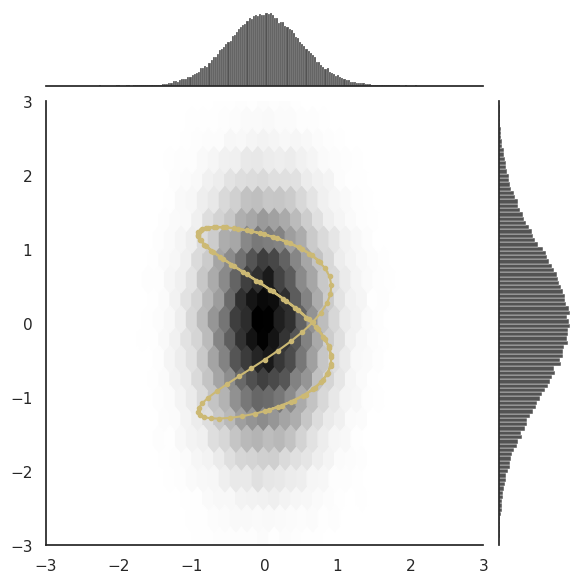

In [4]:
import seaborn as sns

x_lim = [-3, 3]
y_lim = [-3, 3]
sns.set_theme(style="white")

sns.jointplot(x=samples[:,0], y=samples[:,1], xlim=x_lim, ylim=y_lim, gridsize=30, kind="hex", color="k")
plt.plot(*trajectory.T, '.-y')

In [5]:
p_init = jnp.array([-1.0, 1.0])
n = 100
alpha = 1e4
def diagHU(q): return jax.jvp(jax.grad(U), (q,), (jnp.ones_like(q),))[1] # diagonal Hessian (faster than computed with diag(jax.hessian))
def SoftAbsdiagHU(q): return diagHU(q)/jnp.tanh(alpha*diagHU(q)) # THE metric
def eff_U(q): return U(q) + jnp.sum(jnp.log(SoftAbsdiagHU(q)))/2
def T(q,p): return jnp.dot(p, p/(2*SoftAbsdiagHU(q)))
def H(q, p, M): return eff_U(q) + T(q,p)
def sample_p(key, q): return normal(key, q.shape)*SoftAbsdiagHU(q) 
integrator = partial(implicit_leapfrog, 
                        dUdq=jax.grad(eff_U), 
                        dTdq=jax.grad(T, argnums=0), 
                        dTdp=jax.grad(T, argnums=1))

def fun(state, sth):
    q,p = integrator(*state, step_size=.1, num_steps=1, M=1.0)
    return (q,-p), state[0]
_, trajectory = jax.lax.scan(fun, (q_init, p_init), jnp.arange(n))


In [6]:
init_step_size=.3
init_state, hmc_kernel = kernel_factory("p_rmhmc", q_init, init_step_size, U, implicit_leapfrog, num_steps=5)
carry, samples = jax.lax.scan(hmc_kernel, init_state, keys)

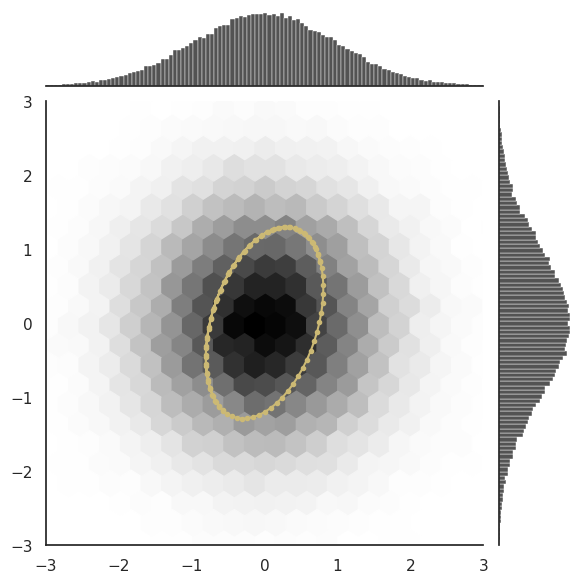

In [7]:
import seaborn as sns

x_lim = [-3, 3]
y_lim = [-3, 3]
sns.set_theme(style="white")

sns.jointplot(x=samples[:,0], y=samples[:,1], xlim=x_lim, ylim=y_lim, gridsize=30, kind="hex", color="k")
plt.plot(*trajectory.T, '.-y')

- Riemannian "flattens" everything to a standard normal

In [8]:
init_step_size=.3

init_state, q_rmhmc = kernel_factory("q_rmhmc", q_init, init_step_size, U, explicit_leapfrog, num_steps=10)
carry, samples = jax.lax.scan(q_rmhmc, init_state, keys)

In [9]:
p_init = jnp.array([-1.0, 1.0])
n = 100
alpha = 1e6
def eff_U(q):  # full Hessian  
    hess_U = jax.hessian(U)
    eig, Q = jnp.linalg.eigh(hess_U(q)) # eigendecomp of a Hermitian matrix
    sigma = jnp.sqrt(eig/jnp.tanh(alpha*eig)) # negative eigenvalue treatment
    return U(Q@q/sigma) + jnp.sum(jnp.log(sigma))

def fun(state, sth):
    q,p = explicit_leapfrog(*state, step_size=.1, num_steps=1, M=1.0, dUdq=jax.grad(eff_U))
    return (q,-p), state[0]
_, trajectory = jax.lax.scan(fun, (q_init, p_init), jnp.arange(n))

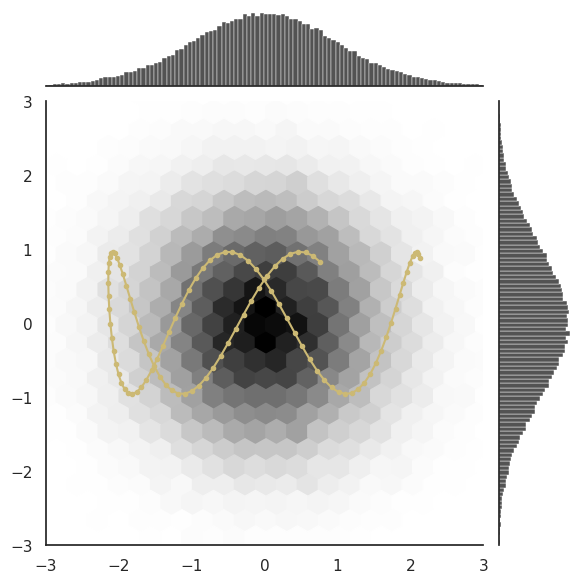

In [10]:
import seaborn as sns

x_lim = [-3, 3]
y_lim = [-3, 3]
sns.set_theme(style="white")

sns.jointplot(x=samples[:,0], y=samples[:,1], xlim=x_lim, ylim=y_lim, gridsize=30, kind="hex", color="k")
plt.plot(*trajectory.T, '.-y')

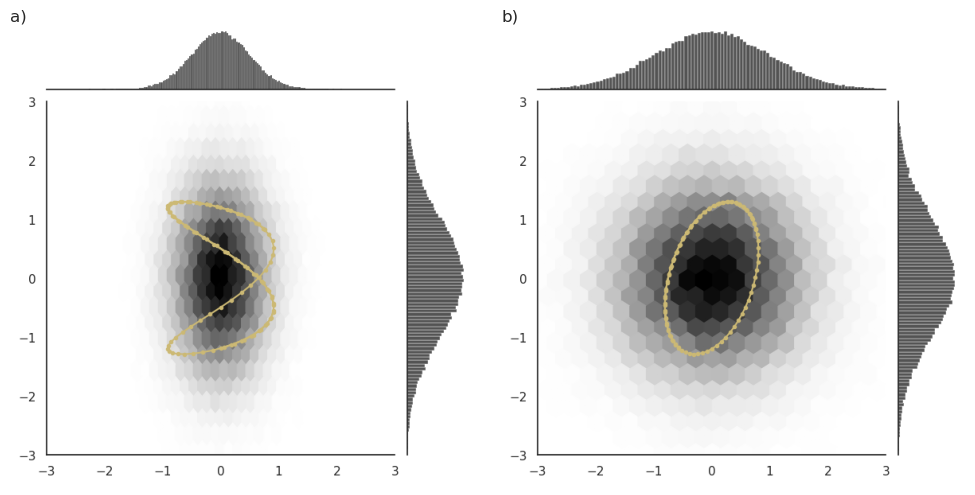

In [11]:
import matplotlib.image as mpimg
f, ax = plt.subplots(1, 2, figsize=(10,5))

ax[0].imshow(mpimg.imread(f'results/2Dgauss.png'))
ax[0].set_axis_off() 
ax[0].annotate(f"a)",(.1,.1)) # unicode for a) b) c)
ax[1].imshow(mpimg.imread(f'results/2driemanngauss.png'))
ax[1].set_axis_off() 
ax[1].annotate(f"b)",(.1,.1)) # unicode for a) b) c)
plt.tight_layout()

## 100-dim funnel


In [12]:
from test_functions import neg_log_funnel, neg_log_nD_funnel

U = neg_log_nD_funnel()
# U = neg_log_funnel()
dim = 20

key, split_key = split(key)
q_init = 2*normal(split_key, (dim, ))
# q_init = jnp.zeros(dim)

### MCMC

In [35]:
num_warmup = 5000
num_samples = 20000
keys = split(key, num=num_samples+num_warmup)
# dual_avg_kwargs = {"tune_steps":num_warmup, "target_accept":0.25}
dual_avg_kwargs = None
prob = lambda x: jnp.exp(-U(x))
init_step_size = .1

init_state, mcmc_kernel = kernel_factory("mcmc", q_init, init_step_size, prob, None, gather_stats=True, dual_avg_kwargs=dual_avg_kwargs)

carry, burned_mcmc_states = jax.lax.scan(mcmc_kernel, init_state, keys[:num_warmup,:]) # warm up
carry, mcmc_states = jax.lax.scan(mcmc_kernel, carry, keys[num_warmup:,:])

In [36]:
if dual_avg_kwargs!=None:
    q, accept_prob, step_size = [np.concatenate((arr, mcmc_states[i])) for i, arr in enumerate(burned_mcmc_states)]
    print(f"Final step size: {step_size[-1]}")

    running_avg_a_rate = np.cumsum(accept_prob)/np.arange(1,num_samples+num_warmup+1)
    print(f"Final average acceptance rate: {running_avg_a_rate[-1]}")


    fig, axes = plt.subplots(1,2, figsize=(15,5))

    x = np.arange(num_warmup)

    axes[0].plot(x, running_avg_a_rate[:num_warmup])
    axes[0].scatter(x, accept_prob[:num_warmup], s=1, c='grey')
    axes[1].plot(x, step_size[:num_warmup])


    x = np.arange(num_warmup, num_samples+num_warmup)
    axes[0].plot(x, running_avg_a_rate[num_warmup:])
    axes[0].scatter(x, accept_prob[num_warmup:], s=1, c='k')
    axes[1].plot(x, step_size[num_warmup:])

print(np.mean(mcmc_states[-1]))

0.8782751


Mean: 2.1954240798950195+/- -0.008157794363796711
ESS: 43.472660064697266


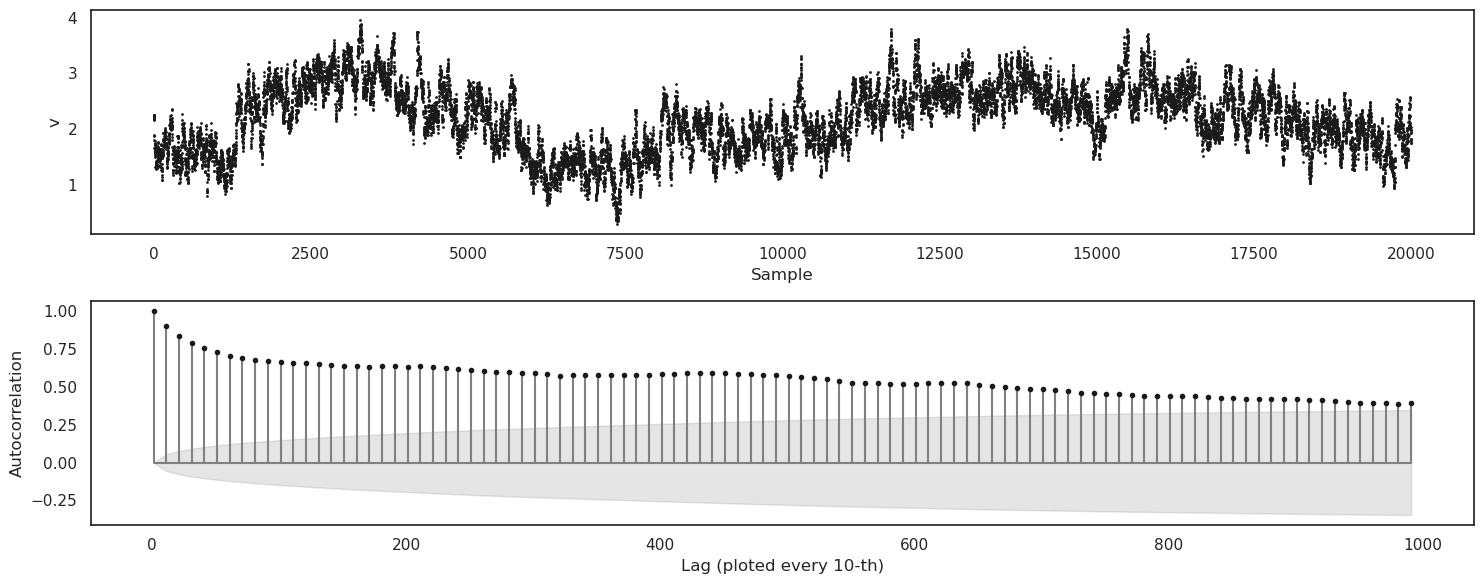

In [37]:
mean, ci = compute_CI(mcmc_states[0][:,-1], .05)
print(f"Mean: {mean}+/- {ci}")
print(f"ESS: {effective_sample_size(mcmc_states[0].T)}")

fig, ax = plt.subplots(2,1, figsize=(15,6))
ax[0].scatter(np.arange(num_samples), mcmc_states[0][:,-1], s=1, c='k')
ax[0].set_ylabel("v")
ax[0].set_xlabel("Sample")
plot_ac(mcmc_states[0][:,-1], lag=1000, plot_every=10, ax=ax[1])
plt.tight_layout()



### HMC

In [16]:
num_warmup = 5000
num_samples = 20000
keys = split(key, num=num_samples+num_warmup)
random_mass_kwargs = {"mu":-.1, "sigma":.3} # this has rouhgly mean 1.0
dual_avg_kwargs = {"tune_steps":num_warmup, "target_accept":0.65}
# dual_avg_kwargs = None
init_step_size=.3 # too small and it will be a random walk too

initial_state, hmc_kernel = kernel_factory("hmc", q_init, init_step_size, U, explicit_leapfrog, num_steps=20, gather_stats=True, dual_avg_kwargs=dual_avg_kwargs, random_mass_kwargs=random_mass_kwargs)

# with jax.disable_jit():
carry, burned_hmc_states = jax.lax.scan(hmc_kernel, initial_state, keys[:num_warmup,:]) # warm up
carry, hmc_states = jax.lax.scan(hmc_kernel, carry, keys[num_warmup:,:])

Final step size: inf
Final average acceptance rate: 0.999199375


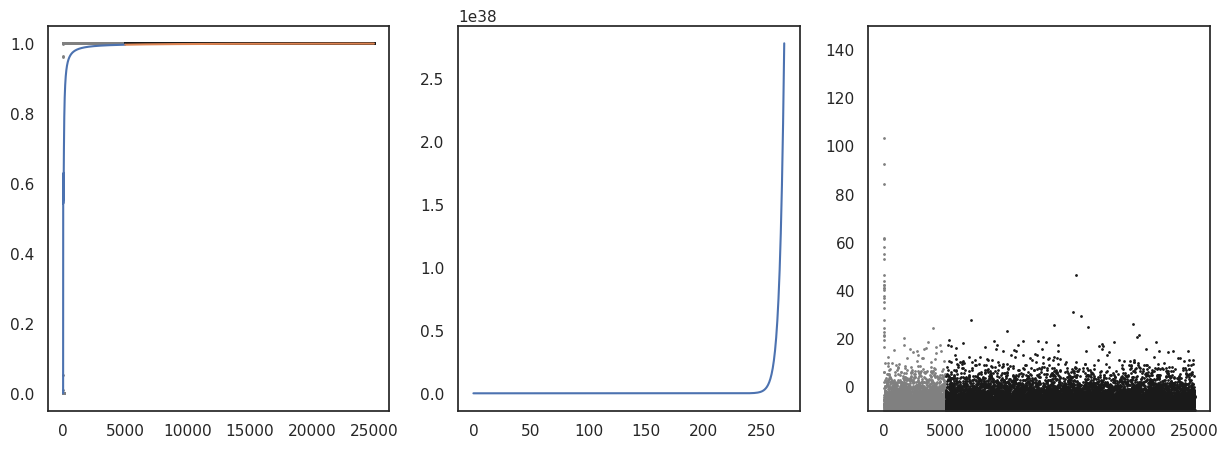

In [17]:
if dual_avg_kwargs!=None:
    q, accept_prob, E_new, step_size = [np.concatenate((arr, hmc_states[i])) for i, arr in enumerate(burned_hmc_states)]
    print(f"Final step size: {step_size[-1]}")

    running_avg_a_rate = np.cumsum(accept_prob)/np.arange(1,num_samples+num_warmup+1)
    print(f"Final average acceptance rate: {running_avg_a_rate[-1]}")


    fig, axes = plt.subplots(1,3, figsize=(15,5))

    x = np.arange(num_warmup)

    axes[0].plot(x, running_avg_a_rate[:num_warmup])
    axes[0].scatter(x, accept_prob[:num_warmup], s=1, c='grey')
    axes[1].plot(x, step_size[:num_warmup])
    axes[2].scatter(x, E_new[:num_warmup], s=1, c='grey')


    x = np.arange(num_warmup, num_samples+num_warmup)
    axes[0].plot(x, running_avg_a_rate[num_warmup:])
    axes[0].scatter(x, accept_prob[num_warmup:], s=1, c='k')
    axes[1].plot(x, step_size[num_warmup:])
    axes[2].scatter(x, E_new[num_warmup:], s=1, c='k')

    axes[2].set_ylim(-10,150)

Mean: -4.466080188751221+/- -0.0
ESS: 10.000499725341797


/home/dawid/miniconda3/lib/python3.9/site-packages/matplotlib/axes/_base.py:2480: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


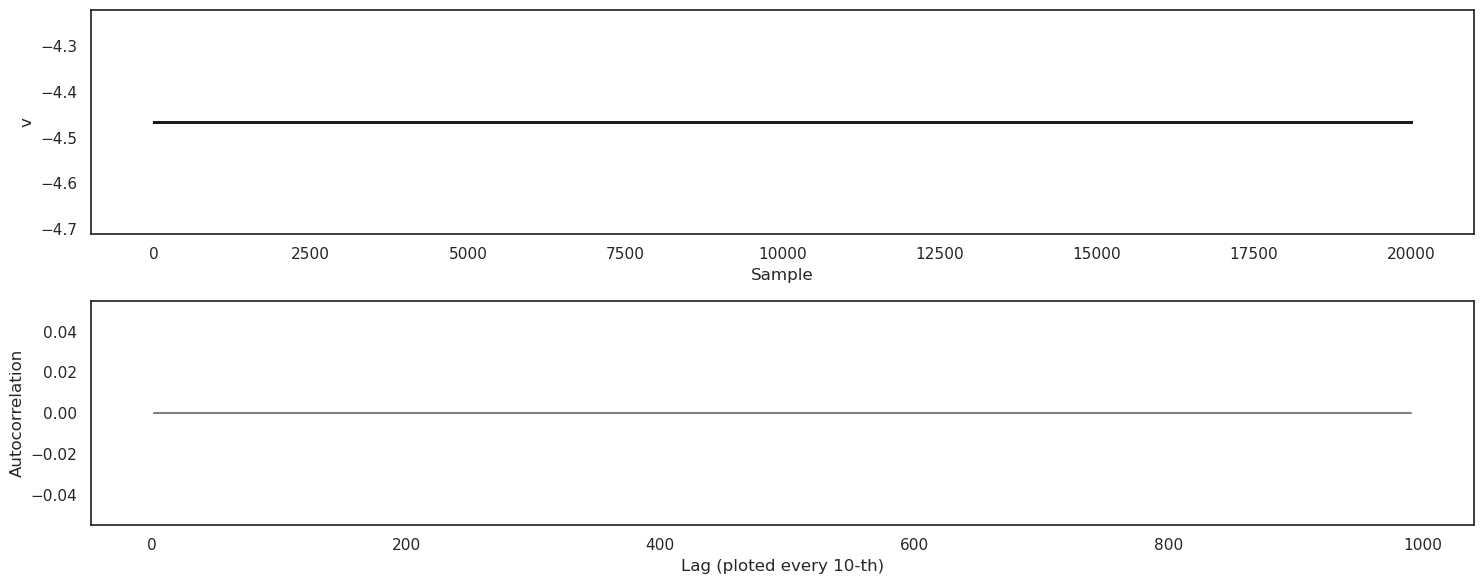

In [18]:
mean, ci = compute_CI(hmc_states[0][:,-1], .05)
print(f"Mean: {mean}+/- {ci}")
print(f"ESS: {effective_sample_size(hmc_states[0].T)}")

fig, ax = plt.subplots(2,1, figsize=(15,6))
ax[0].scatter(np.arange(num_samples), hmc_states[0][:,-1], s=1, c='k')
ax[0].set_ylabel("v")
ax[0].set_xlabel("Sample")
plot_ac(hmc_states[0][:,-1], lag=1000, plot_every=10, ax=ax[1])
plt.tight_layout()

### q RMHCM

In [19]:
num_warmup = 5000
num_samples = 20000
keys = split(key, num=num_samples+num_warmup)
random_mass_kwargs = {"mu":-.1, "sigma":.3} # this has rouhgly mean 1.0
# random_mass_kwargs = None
dual_avg_kwargs = {"tune_steps":num_warmup, "target_accept":0.8}
# dual_avg_kwargs = None
init_step_size=.1 # too small and it will be a random walk too

initial_state, q_rmhmc = kernel_factory("q_rmhmc", q_init, init_step_size, U, explicit_leapfrog, num_steps=5, gather_stats=True, dual_avg_kwargs=dual_avg_kwargs, SoftAbs_alpha=10)

# with jax.disable_jit():
carry, burned_q_rmhmc_states = jax.lax.scan(q_rmhmc, initial_state, keys[:num_warmup,:]) # warm up
carry, q_rmhmc_states = jax.lax.scan(q_rmhmc, carry, keys[num_warmup:,:])

Final step size: inf
Final average acceptance rate: 0.988941875


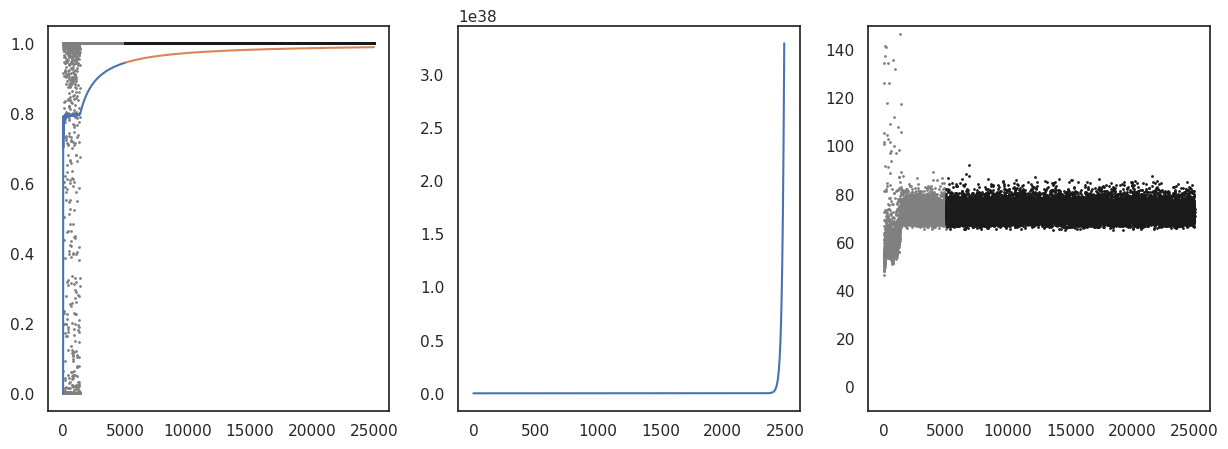

In [20]:
if dual_avg_kwargs!=None:
    q, accept_prob, E_new, step_size = [np.concatenate((arr, q_rmhmc_states[i])) for i, arr in enumerate(burned_q_rmhmc_states)]
    print(f"Final step size: {step_size[-1]}")

    running_avg_a_rate = np.cumsum(accept_prob)/np.arange(1,num_samples+num_warmup+1)
    print(f"Final average acceptance rate: {running_avg_a_rate[-1]}")


    fig, axes = plt.subplots(1,3, figsize=(15,5))

    x = np.arange(num_warmup)

    axes[0].plot(x, running_avg_a_rate[:num_warmup])
    axes[0].scatter(x, accept_prob[:num_warmup], s=1, c='grey')
    axes[1].plot(x, step_size[:num_warmup])
    axes[2].scatter(x, E_new[:num_warmup], s=1, c='grey')


    x = np.arange(num_warmup, num_samples+num_warmup)
    axes[0].plot(x, running_avg_a_rate[num_warmup:])
    axes[0].scatter(x, accept_prob[num_warmup:], s=1, c='k')
    axes[1].plot(x, step_size[num_warmup:])
    axes[2].scatter(x, E_new[num_warmup:], s=1, c='k')

    axes[2].set_ylim(-10,150)

Mean: -1.4047225713729858+/- -1.6522673229601992e-09
ESS: 10.000499725341797


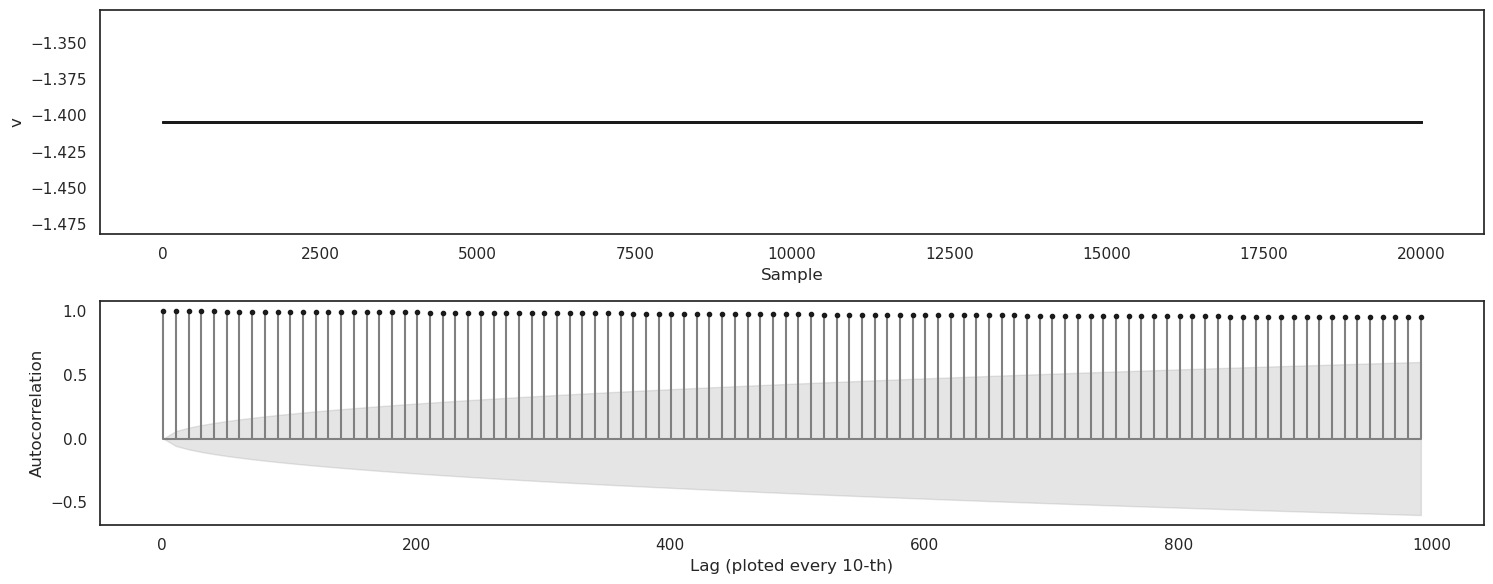

In [21]:
mean, ci = compute_CI(q_rmhmc_states[0][:,-1], .05)
print(f"Mean: {mean}+/- {ci}")
print(f"ESS: {effective_sample_size(q_rmhmc_states[0].T)}")

fig, ax = plt.subplots(2,1, figsize=(15,6))
ax[0].scatter(np.arange(num_samples), q_rmhmc_states[0][:,-1], s=1, c='k')
ax[0].set_ylabel("v")
ax[0].set_xlabel("Sample")
plot_ac(q_rmhmc_states[0][:,-1], lag=1000, plot_every=10, ax=ax[1])
plt.tight_layout()

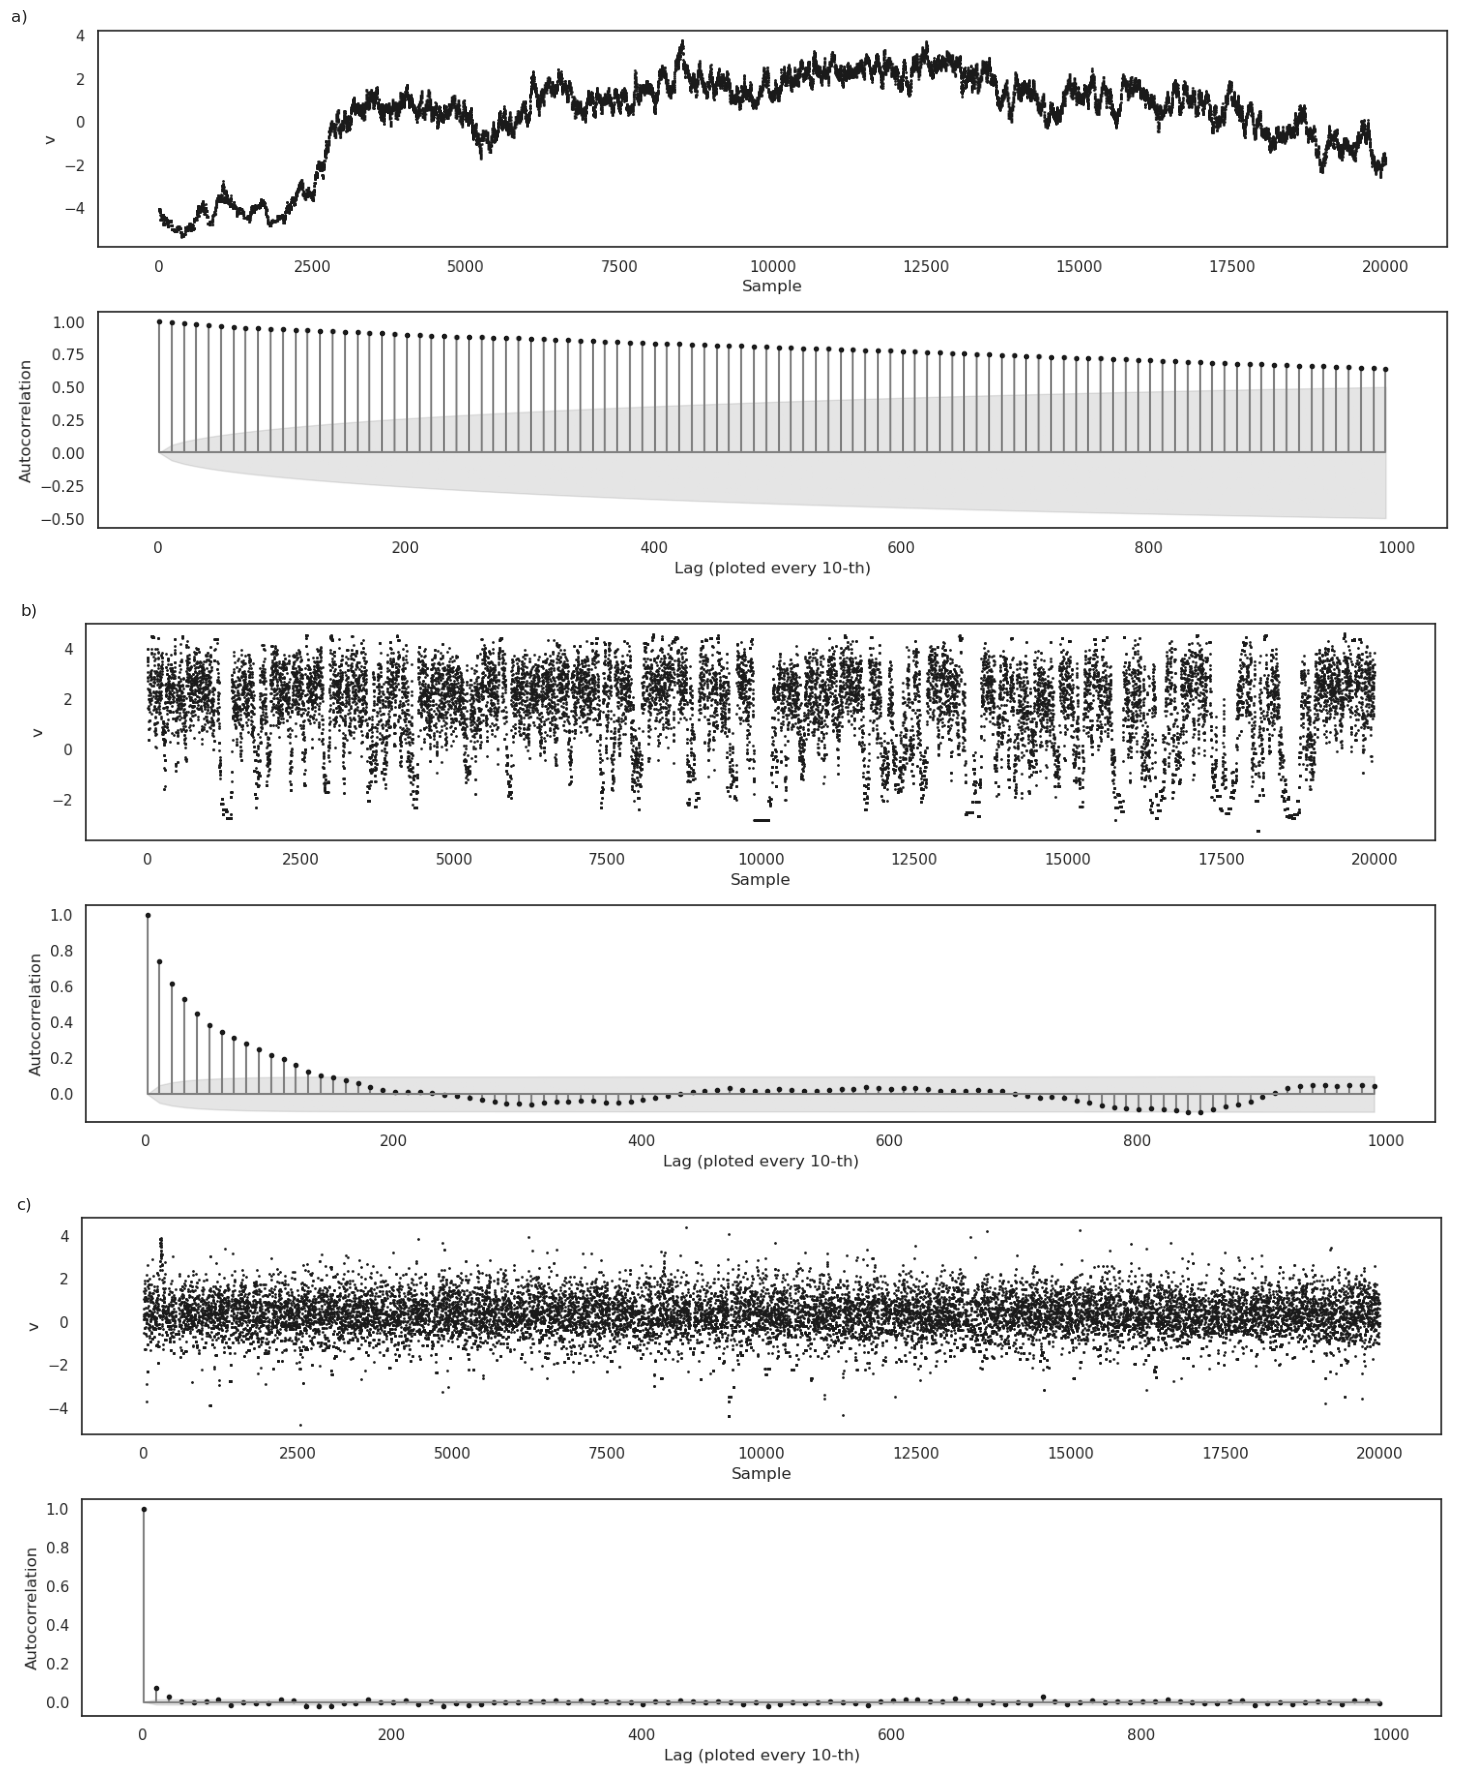

In [22]:
import matplotlib.image as mpimg
f, ax = plt.subplots(3, 1, figsize=(15, 18))

ax[0].imshow(mpimg.imread(f'results/2dfunnel.png'))
ax[0].set_axis_off() 
ax[0].annotate(f"a)",(.1,.1)) # unicode for a) b) c)
ax[1].imshow(mpimg.imread(f'results/2dfunnel2.png'))
ax[1].set_axis_off() 
ax[1].annotate(f"b)",(.1,.1)) # unicode for a) b) c)
ax[2].imshow(mpimg.imread(f'results/2dfunnel3.png'))
ax[2].set_axis_off() 
ax[2].annotate(f"c)",(.1,.1)) # unicode for a) b) c)
plt.tight_layout()

### DiagRMHMC

In [23]:
# num_warmup = 0
# num_samples = 500
# keys = split(key, num=num_samples+num_warmup)
# # dual_avg_kwargs = {"tune_steps":10000, "target_accept":0.95}
# dual_avg_kwargs = None
# init_step_size=.3
# # q_init = jnp.array([0.0, 0.0])

# for soft in [1, 10, 100, 1000]:
#     initial_state, p_rmhmc_kernel = kernel_factory("p_rmhmc", q_init, init_step_size, U, implicit_leapfrog, num_steps=10, gather_stats=True, dual_avg_kwargs=dual_avg_kwargs, SoftAbs_alpha=soft)

#     carry, burned_p_rmhmc_states = jax.lax.scan(p_rmhmc_kernel, initial_state, keys[:num_warmup,:]) # warm up
#     carry, p_rmhmc_states = jax.lax.scan(p_rmhmc_kernel, carry, keys[num_warmup:,:])

#     plt.figure(figsize=(15,5))
#     plt.scatter(np.arange(num_samples), p_rmhmc_states[0][:,-1], s=1, c='k')
#     plt.ylabel("v")
#     plt.xlabel("Sample")
#     plt.title(f"Softabs {soft}")
#     plot_ac(p_rmhmc_states[0][:,-1], lag=1000, plot_every=10)

In [24]:
# num_warmup = 0
# num_samples = 20000
# keys = split(key, num=num_samples+num_warmup)
# # dual_avg_kwargs = {"tune_steps":5000, "target_accept":0.8}
# dual_avg_kwargs = None
# init_step_size=.5
# # q_init = jnp.array([0.0, 0.0])


# initial_state, p_rmhmc_kernel = kernel_factory("p_rmhmc", q_init, init_step_size, U, implicit_leapfrog, num_steps=5, gather_stats=True, dual_avg_kwargs=dual_avg_kwargs, SoftAbs_alpha=10)

# carry, burned_p_rmhmc_states = jax.lax.scan(p_rmhmc_kernel, initial_state, keys[:num_warmup,:]) # warm up
# carry, p_rmhmc_states = jax.lax.scan(p_rmhmc_kernel, carry, keys[num_warmup:,:])

# plt.figure(figsize=(15,5))
# plt.scatter(np.arange(num_samples), p_rmhmc_states[0][:,-1], s=1, c='k')
# plt.ylabel("v")
# plt.xlabel("Sample")
# plot_ac(p_rmhmc_states[0][:,-1], lag=1000, plot_every=10)

In [25]:
# if dual_avg_kwargs!=None:
#     q, accept_prob, E_new, step_size = [np.concatenate((arr, p_rmhmc_states[i])) for i, arr in enumerate(burned_p_rmhmc_states)]
#     print(f"Final step size: {step_size[-1]}")

#     running_avg_a_rate,_,_ = compute_stats(np.expand_dims(accept_prob, axis=1))
#     print(f"Final average acceptance rate: {running_avg_a_rate[-1]}")


#     fig, axes = plt.subplots(1,3, figsize=(15,5))

#     x = np.arange(num_warmup)

#     axes[0].plot(x, running_avg_a_rate[:num_warmup])
#     axes[0].scatter(x, accept_prob[:num_warmup], s=1, c='grey')
#     axes[1].plot(x, step_size[:num_warmup])
#     axes[2].scatter(x, E_new[:num_warmup], s=1, c='grey')


#     x = np.arange(num_warmup, num_samples+num_warmup)
#     axes[0].plot(x, running_avg_a_rate[num_warmup:])
#     axes[0].scatter(x, accept_prob[num_warmup:], s=1, c='k')
#     axes[1].plot(x, step_size[num_warmup:])
#     axes[2].scatter(x, E_new[num_warmup:], s=1, c='k')

#     axes[2].set_ylim(-10,150)

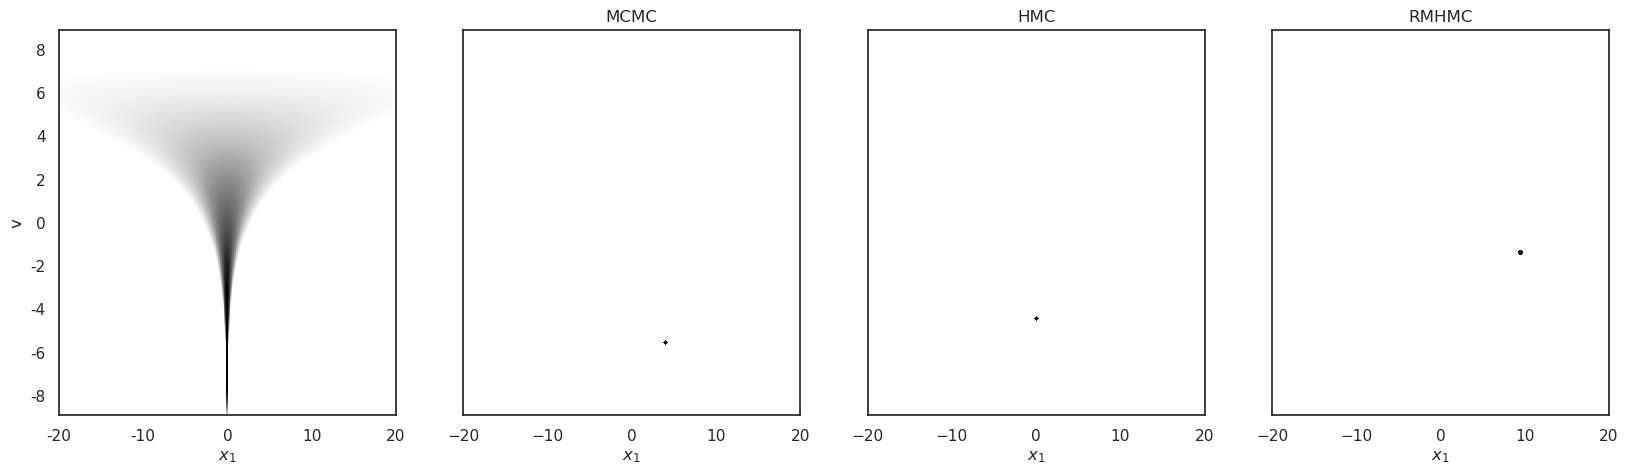

In [26]:

x_lim = [-20, 20]
y_lim = [-9, 9]
res = 500
x, y = np.meshgrid(np.linspace(*x_lim, res), np.linspace(*y_lim, res))
pos = np.dstack((x, y))
logp = -jax.vmap(jax.vmap(U))(pos)

fig, ax = plt.subplots(1,4, figsize=(20,5))

# ax.contourf(pos[...,0], pos[...,1], logp, levels=np.linspace(-7.5,-2.5,50), alpha=0.9)
ax[0].pcolor(logp[:,:-2], vmin=-8, vmax=-2.5, cmap="Greys")
x_labels = [-20,-10,0,10,20]
ax[0].set_xticks(np.linspace(0,res,len(x_labels)))
ax[0].set_xticklabels(x_labels)
y_labels = np.arange(-8,9,2)
ax[0].set_yticks(25+np.linspace(0,res-50,len(y_labels)))
ax[0].set_yticklabels(y_labels)
ax[0].set_ylabel("v")
ax[0].set_xlabel("$x_1$") # actually x_last but it's just a multivariate gaussian

ax[1].set_title("MCMC")
ax[1].scatter(*mcmc_states[0][::5,-2:].T, s=2, c="k", alpha=0.1)

ax[2].set_title("HMC")
ax[2].scatter(*hmc_states[0][::5,-2:].T, s=2, c="k", alpha=0.1)

# ax[3].set_title("p_RMHMC")
# ax[3].scatter(*p_rmhmc_states[0][::5,-2:].T, s=2, c="k", alpha=0.3)

ax[-1].set_title("RMHMC")
ax[-1].scatter(*q_rmhmc_states[0][::5,-2:].T, s=2, c="k", alpha=0.3)

for i in range(1,4):
    ax[i].set_xlabel("$x_1$") # actually x_last but it's just a multivariate gaussian
    ax[i].set_xlim(*x_lim)
    ax[i].set_ylim(*y_lim)
    ax[i].set_yticks([])

Text(0.5, 0, '$x_1$')

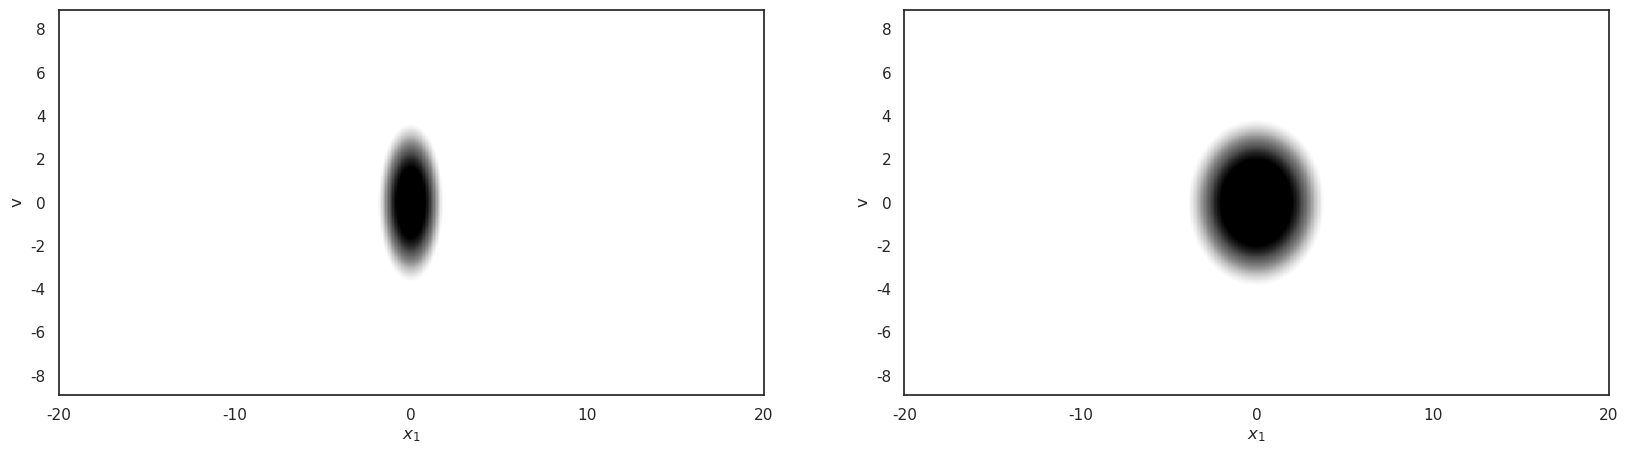

In [27]:

U = lambda x: -jst.multivariate_normal.logpdf(x, mu, cov)

def diagHU(q): return jax.jvp(jax.grad(U), (q,), (jnp.ones_like(q),))[1]
def eff_U(q): 
    """ Diagonal Hessian"""   
    eig = diagHU(q) # eigendecomp of a Hermitian matrix
    sigma = jnp.sqrt(eig/jnp.tanh(alpha*eig)) # negative eigenvalue treatment
    return U(q/sigma) - jnp.sum(jnp.log(sigma))

x_lim = [-20, 20]
y_lim = [-9, 9]
res = 500
x, y = np.meshgrid(np.linspace(*x_lim, res), np.linspace(*y_lim, res))
pos = np.dstack((x, y))
logp = -jax.vmap(jax.vmap(U))(pos)
logpeff = -jax.vmap(jax.vmap(eff_U))(pos)

fig, ax = plt.subplots(1,2, figsize=(20,5))

# ax.contourf(pos[...,0], pos[...,1], logp, levels=np.linspace(-7.5,-2.5,50), alpha=0.9)
ax[0].pcolor(logp[:,:-2], vmin=-8, vmax=-2.5, cmap="Greys")
x_labels = [-20,-10,0,10,20]
ax[0].set_xticks(np.linspace(0,res,len(x_labels)))
ax[0].set_xticklabels(x_labels)
y_labels = np.arange(-8,9,2)
ax[0].set_yticks(25+np.linspace(0,res-50,len(y_labels)))
ax[0].set_yticklabels(y_labels)
ax[0].set_ylabel("v")
ax[0].set_xlabel("$x_1$") # actually x_last but it's just a multivariate gaussian

ax[1].pcolor(logpeff[:,:-2], vmin=-8, vmax=-2.5, cmap="Greys")
x_labels = [-20,-10,0,10,20]
ax[1].set_xticks(np.linspace(0,res,len(x_labels)))
ax[1].set_xticklabels(x_labels)
y_labels = np.arange(-8,9,2)
ax[1].set_yticks(25+np.linspace(0,res-50,len(y_labels)))
ax[1].set_yticklabels(y_labels)
ax[1].set_ylabel("v")
ax[1].set_xlabel("$x_1$") # actually x_last but it's just a multivariate gaussian

In [28]:
# def neg_log_normal(mu, sigma):
#     """
#     -logp(x | mu, sigma) = 0.5 * log(2π) + log(σ) + 0.5 * ((x - μ)/σ)^2
#     """
#     def nlogp(x):
#         return 0.5 * (jnp.log(2 * jnp.pi * sigma * sigma) + ((x - mu) / sigma) ** 2)

#     return nlogp

# def neg_log_funnel():
#     """Neal's 1+1D funnel
#         p(x,v) = N(v | 0, 9) N(x | 0, exp(v) I )
#     """
#     scale = neg_log_normal(0, 1) 
#     def neg_log_p(x): # v = x[-1]
#         funnel = neg_log_normal(0, jnp.exp(x[1]))
#         return scale(x[1]) + funnel(x[0])
#     return neg_log_p

U = neg_log_funnel()
alpha = 2

def diagHU(q): return jax.jvp(jax.grad(U), (q,), (jnp.ones_like(q),))[1]
def eff_U(q): 
    """ Diagonal Hessian"""   
    eig = diagHU(q) # eigendecomp of a Hermitian matrix
    # sigma = jnp.sqrt(jnp.absolute(eig)) # negative eigenvalue treatment
    sigma = jnp.sqrt(eig/jnp.tanh(alpha*eig)) # negative eigenvalue treatment
    return U(q*sigma) - jnp.sum(jnp.log(sigma))

def full_eff_U(q):  # full Hessian  
    hess_U = jax.hessian(U)
    eig, Q = jnp.linalg.eigh(hess_U(q)) # eigendecomp of a Hermitian matrix
    sigma = jnp.sqrt(eig/jnp.tanh(alpha*eig)) # negative eigenvalue treatment
    return U((Q@q)/sigma) + jnp.sum(jnp.log(sigma))

def true_eff_U(q): return U(q*jnp.array([jnp.exp(q[-1]),1.0])) - q[-1]


for q in jnp.column_stack((np.zeros(10), np.linspace(-5,5,10))):
    # print(eff_U(i), true_eff_U(i))
    print(U(q/jnp.sqrt(diagHU(q)/jnp.tanh(alpha*diagHU(q)))), U(q*jnp.array([jnp.exp(q[-1]),1.0])))

# plt.plot(q[:,-1], foo_U, label="computed")
# plt.plot(q[:,-1], true_foo_U, label="true")
# plt.legend()

x_lim = [-6, 6]
y_lim = [-6, 6]
res = 500
x, y = np.meshgrid(np.linspace(*x_lim, res), np.linspace(*y_lim, res))
pos = np.dstack((x, y))
logp = -jax.vmap(jax.vmap(U))(pos)
fulllogpeff = -jax.vmap(jax.vmap(full_eff_U))(pos)
logpeff = -jax.vmap(jax.vmap(eff_U))(pos)
truelogpeff = -jax.vmap(jax.vmap(true_eff_U))(pos)

fig, ax = plt.subplots(1,4, figsize=(15,5))

# ax.contourf(pos[...,0], pos[...,1], logp, levels=np.linspace(-7.5,-2.5,50), alpha=0.9)
ax[0].pcolor(logp[:,:-2], vmin=-8, vmax=-2.5, cmap="Greys")
ax[0].set_aspect('equal')
ax[0].set_ylabel("v")
ax[0].set_xlabel("$x_1$") # actually x_last but it's just a multivariate gaussian

ax[1].pcolor(fulllogpeff[:,:-2], vmin=-8, vmax=-2.5, cmap="Greys")
ax[1].set_aspect('equal')
ax[1].set_ylabel("v")
ax[1].set_xlabel("$x_1$") # actually x_last but it's just a multivariate gaussian

ax[2].pcolor(logpeff[:,:-2], vmin=-8, vmax=-2.5, cmap="Greys")
ax[2].set_aspect('equal')
ax[2].set_ylabel("v")
ax[2].set_xlabel("$x_1$") # actually x_last but it's just a multivariate gaussian

ax[-1].pcolor(truelogpeff[:,:-2], vmin=-8, vmax=-2.5, cmap="Greys")
ax[-1].set_aspect('equal')
ax[-1].set_ylabel("v")
ax[-1].set_xlabel("$x_1$") # actually x_last but it's just a multivariate gaussian

-2.7266684 -0.8105774
-1.2773871 0.23956752
0.20237064 1.3049537
1.7126051 2.3855817
3.2533169 3.4814513
4.824506 4.592562
6.4261713 5.718915
8.058313 6.860509
9.720934 8.017345
11.41403 9.189423
